# CSE 547 Final Project

Emily Yan, Gasper Qian, Dongyang Wang

### Setup

Let's setup Spark on your Colab environment.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=859a409bf07de363c6aedceac905474b4448af5d4720183ca82ddeb3b4a8ccd6
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 22 not

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.rdd import RDD
import numpy as np
import pandas as pd

In [ ]:
conf = SparkConf().set("spark.ui.port", "4050")
sc = SparkContext(conf=conf)
spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config("spark.executor.memory", "70g")\
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','50g') \
.config("spark.memory.offHeap.size","16g")   \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

#sc.stop()

The following code will be used for using and mounting Google drive.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Unzipping and Loading the Data

Obtaining the dataset from the web.

In [ ]:
!wget --no-check-certificate http://drive.jku.at/ssf/s/readFile/share/1056/266403063659030189/publicLink/LFM-1b.zip
!unzip LFM-1b.zip

URL transformed to HTTPS due to an HSTS policy
--2023-03-06 00:54:39--  https://drive.jku.at/ssf/s/readFile/share/1056/266403063659030189/publicLink/LFM-1b.zip
Resolving drive.jku.at (drive.jku.at)... 140.78.3.239
Connecting to drive.jku.at (drive.jku.at)|140.78.3.239|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 8672428478 (8.1G) [application/zip]
Saving to: ‘LFM-1b.zip.4’

LFM-1b.zip.4          0%[                    ]  55.26K   167KB/s               ^C
Archive:  LFM-1b.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of LFM-1b.zip or
        LFM-1b.zip.zip, and cannot find LFM-1b.zip.ZIP, period.


The following code will be used for reading the dataset from Google drive.

In [ ]:
#from zipfile import ZipFile

# specifying the zip file name
#file_name = "/content/drive/MyDrive/CSE 547/LFM-1b.zip"

#with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    #zip.extractall()
    print('Done!')

IndentationError: ignored

In [ ]:
#import zipfile
#archive = zipfile.ZipFile('/content/drive/MyDrive/CSE 547/LFM-1b.zip', 'r')

#albums = archive.read("LFM-1b_albums.txt")
#artists = archive.read("LFM-1b_artists.txt")
#LEs = archive.read("LFM-1b_LEs.txt")
#tracks = archive.read("LFM-1b_tracks.txt")
#users = archive.read("LFM-1b_users.txt")
#users_additional = archive.read("LFM-1b_users_additional.txt")

In [ ]:
albums = "LFM-1b_albums.txt"
artists = "LFM-1b_artists.txt"
LEs = "LFM-1b_LEs.txt"
tracks = "LFM-1b_tracks.txt"
users = "LFM-1b_users.txt"
users_additional = "LFM-1b_users_additional.txt"

In [ ]:
UAM_MATLAB_FILE = 'LFM-1b_LEs.mat' 

### EDA

Initializing

In [ ]:
UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'         # Matlab .mat file where the listening events are stored
ARTISTS_FILE = "LFM-1b_artists.txt"        # artist names for UAM
USERS_FILE = "LFM-1b_users.txt"            # user names for UAM
K = 3                                      # maximum number of seed's neighbors to select

In [ ]:
# Load required modules
import csv
import numpy as np
import h5py
from scipy import sparse

# Read the user-artist-matrix and corresponding artist and user indices from Matlab file
def read_UAM(m_file):
    mf = h5py.File(m_file, 'r')
    user_ids = np.array(mf.get('idx_users')).astype(np.int64)
    artist_ids = np.array(mf.get('idx_artists')).astype(np.int64)
    # Load UAM
    UAM = sparse.csr_matrix((mf['/LEs/']["data"],
                             mf['/LEs/']["ir"],
                             mf['/LEs/']["jc"])).transpose()    #.tocoo().transpose()
    # user and artist indices to access UAM
    UAM_user_idx = UAM.indices #UAM.row -> for COO matrix
    UAM_artist_idx = UAM.indptr #UAM.col -> for COO matrix
    return UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids

# Function to read metadata (users or artists)
def read_from_file(filename, col):                  # col = column to read from file
    data = []
    with open(filename, 'r') as f:                  # open file for reading
        reader = csv.reader(f, delimiter='\t')      # create reader
        headers = next(reader)                     # skip header
        for row in reader:
            item = row[col]
            data.append(item)
    f.close()
    return data


In [ ]:
UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids = read_UAM(UAM_MATLAB_FILE)

In [ ]:
# Initialize variables
artists = []            # artists
users = []              # users
users_initial = []

# Load metadata from provided files into lists
artists = read_from_file(ARTISTS_FILE, 1)
users_initial = read_from_file(USERS_FILE, 0)

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
USER_FILE = 'LFM-1b_users.txt'
countries=  read_from_file(USER_FILE, 1)

In [ ]:
countrycount = Counter(countries)
countrycount = sorted(countrycount .items(), key=lambda kv:
                 (kv[1], kv[0]))

Text(0.5, 1.0, 'Count of Users from Top20 Countries')

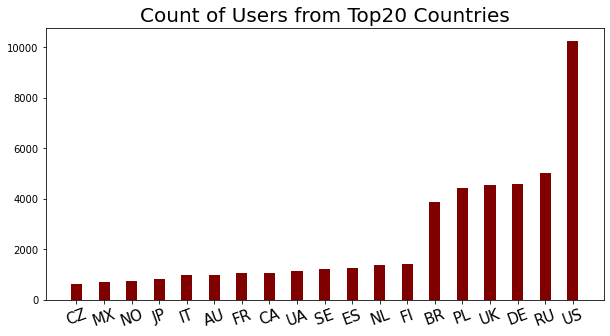

In [ ]:
import matplotlib.pyplot as plt
 
# creating the dataset
courses = list(dict(countrycount[-20:-1]).keys())
values = list(dict(countrycount[-20:-1]).values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
plt.xticks(size = 15, rotation = 20)
plt.title('Count of Users from Top20 Countries',
          size = 20)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text major ticklabel objects>)

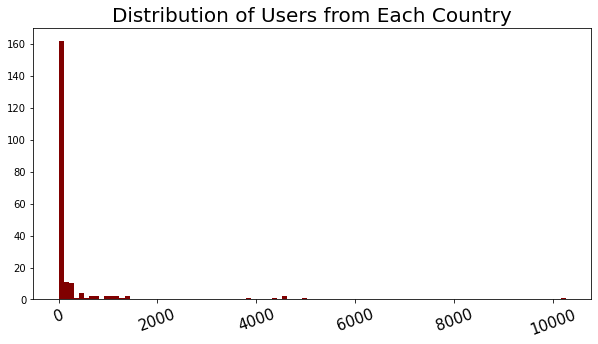

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
#plt.bar(courses, values, color ='maroon',
 #       width = 0.4)
plt.title('Distribution of Users from Each Country',
          size = 20)

_= plt.hist(dict(countrycount[:-1]).values(), bins = 100, color ='maroon')
plt.xticks(size = 15, rotation = 20)

Counts of each unique value in the list: {'m': 39969, 'n': 64339, '': 212, 'f': 15802}


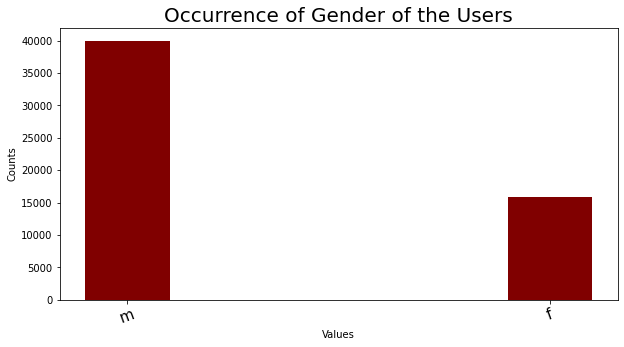

In [ ]:
# User gender distributions
USERS_FILE = 'LFM-1b_users.txt'
users_gender = read_from_file(USERS_FILE, 3)
def count_occurrences(lst):
    return dict(Counter(lst))

gender_counts = count_occurrences(users_gender)
print("Counts of each unique value in the list:", gender_counts)

male_female = {k: v for k, v in gender_counts.items() if k in ["m","f"]}
fig = plt.figure(figsize = (10, 5))
def plot_occurrences(counts):

    plt.bar(counts.keys(), counts.values(), color ='maroon',
        width = 0.2)
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.xticks(size = 15, rotation = 20)
    plt.title('Occurrence of Gender of the Users',
          size = 20)
    plt.show()

plot_occurrences(male_female)

Text(0.5, 1.0, 'Count of Users of Each Age Group')

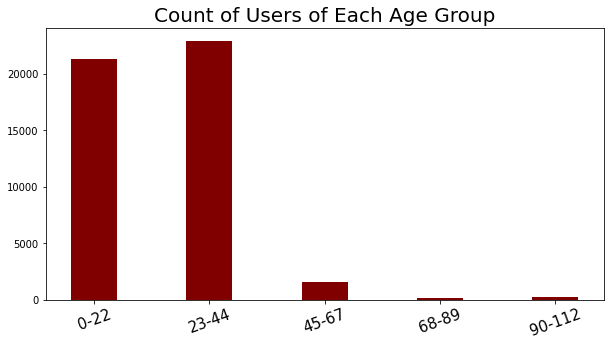

In [ ]:
ages =  read_from_file(USER_FILE, 2)
ages =  [int(i) for i in ages if i!='-1']
agesbin = np.histogram(ages, bins=5)
agesgroup = ['0-22', '23-44', '45-67', '68-89', '90-112']
# creating the bar plot
fig = plt.figure(figsize = (10, 5))
plt.bar(agesgroup, agesbin[0], color ='maroon',
        width = 0.4)
plt.xticks(size = 15, rotation = 20)
plt.title('Count of Users of Each Age Group',
          size = 20)

In [ ]:
UAM.eliminate_zeros()

In [ ]:
uamdata = UAM.data

In [ ]:
quantiles = np.quantile(uamdata, np.arange(10) * 0.1 + 0.1)

In [ ]:
 np.arange(10) * 0.1 + 0.1

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Text(0.5, 1.0, 'Distribution of Quantiles of Play Counts 0-90th quantile')

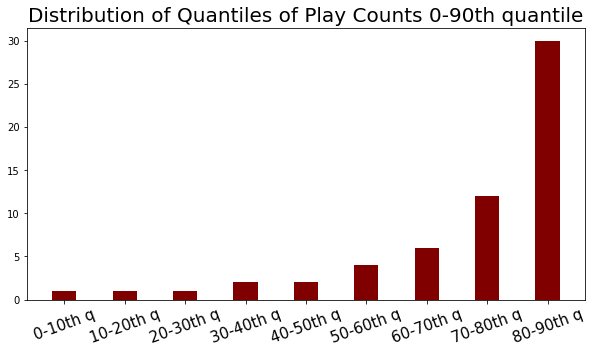

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['0-10th q', '10-20th q', '20-30th q', '30-40th q', '40-50th q',
         '50-60th q', '60-70th q', '70-80th q', '80-90th q'], quantiles[:-1] , color ='maroon',
        width = 0.4)
plt.xticks(size = 15, rotation = 20)
plt.title('Distribution of Quantiles of Play Counts 0-90th quantile',
          size = 20)

In [ ]:
#fig = plt.figure(figsize = (10, 5))

#groupcountdict = {}
#groupcountdict.keys = groupnames
#groupcountdict.values = list(groupcount.values())
#groupcountdict = sorted(groupcountdict.items(), key=lambda kv:
#                 (kv[1], kv[0]))

# creating the bar plot
#plt.bar(courses, list(groupcount.values()), color ='maroon',
#        width = 0.4)
#plt.title('Count of Users from Top20 Countries')

### Sampling

In [ ]:
# Dataset sampling (2000 users)
import random

user_idx = np.arange(0,len(user_ids))
users_samp =random.sample(list(user_idx), 2000)

random.seed(42)
random.shuffle(users_samp)

# Initialize variables
artists = []            # artists
users = []              # users
users_initial = []

# Load metadata from provided files into lists
artists = read_from_file(ARTISTS_FILE, 1)
users_initial = read_from_file(USERS_FILE, 0)

# Save users id for future modeling use
users = [users_initial[i] for i in users_samp]

samp_UAM = UAM[users_samp,:]
rows, columns = samp_UAM.shape
print("Number of rows:", rows)
print("Number of columns:", columns)  

Number of rows: 2000
Number of columns: 585095


In [ ]:
# for each user, sample our indices of nonzeros to be changed to 0s in training set
cols_to_zeros = []

for user in range(rows):
  # get all non-zero col indices
  _, artists_index = samp_UAM[user, :].nonzero()
  len_samp_nonzeros = int(0.1*len(artists_index))
  
  # make sure test set has at least one entry
  if len_samp_nonzeros <= 0:
    len_samp_nonzeros = 1
  
  # sample col indices to be changed to 0
  col_to_zero = random.sample(list(artists_index), len_samp_nonzeros)
  user_id = users[user]
  cols_to_zeros.append((user_id, col_to_zero))

In [ ]:
# construct the training set and test set
# test_samp_UAM = samp_UAM.copy()

# 1s to be changed to 0s in training set
train_samp_UAM = samp_UAM.copy()

for user in range(rows): 
  col_to_zero = cols_to_zeros[user][1]
  train_samp_UAM[user, col_to_zero] = 0

Sanity check below

In [ ]:
train_samp_UAM[1,cols_to_zeros[1][1]].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [ ]:
# Code for sanity check
type(samp_UAM)
samp_UAM[1,cols_to_zeros[1][1]].todense()
train_samp_UAM[1,cols_to_zeros[1][1]].todense()
samp_UAM[:,cols_to_zeros[1][1]].todense()
cols_to_zeros[1][1]
len(cols_to_zeros[1][1])
len(samp_UAM[1, :].nonzero()[1])
samp_UAM[1,cols_to_zeros[1][1]].todense().shape

(1, 148)

In [ ]:
samp_UAM[1,cols_to_zeros[1][1]].todense()

matrix([[7.000e+01, 1.000e+00, 1.000e+00, 8.150e+02, 8.000e+00,
         1.000e+00, 1.000e+00, 2.000e+00, 1.120e+02, 4.000e+00,
         1.000e+00, 1.000e+00, 1.000e+00, 1.900e+01, 1.000e+00,
         1.000e+00, 1.300e+01, 1.333e+03, 4.400e+01, 1.000e+00,
         1.700e+01, 9.100e+01, 2.000e+00, 5.980e+02, 2.000e+00,
         1.000e+00, 1.000e+01, 1.000e+00, 1.000e+00, 8.800e+01,
         2.000e+00, 3.000e+00, 4.000e+00, 2.100e+01, 2.000e+00,
         2.210e+02, 1.800e+01, 1.000e+00, 2.400e+01, 2.000e+00,
         4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
         5.000e+00, 1.000e+00, 2.000e+01, 1.000e+00, 1.000e+00,
         1.000e+00, 1.000e+00, 1.000e+00, 3.700e+01, 2.000e+00,
         1.000e+00, 2.000e+00, 7.390e+02, 1.000e+00, 1.000e+00,
         3.000e+00, 1.130e+02, 1.000e+01, 1.000e+00, 9.000e+00,
         1.000e+00, 8.000e+00, 1.000e+00, 6.000e+00, 1.000e+00,
         2.000e+00, 9.740e+02, 1.000e+00, 3.100e+01, 2.230e+02,
         1.000e+00, 1.000e+00, 1.000e+00

In [ ]:
cols_to_zeros[1][1]

[29844,
 5427,
 215305,
 18774,
 9024,
 25734,
 511,
 233136,
 375,
 2604,
 23299,
 20715,
 30135,
 26515,
 3682,
 13464,
 75869,
 2374,
 9687,
 544953,
 10281,
 14269,
 18001,
 2211,
 15624,
 35709,
 46345,
 1539,
 5377,
 26936,
 1913,
 6469,
 25226,
 5467,
 2341,
 1338,
 299,
 8224,
 16620,
 82508,
 20858,
 5480,
 2642,
 10918,
 57561,
 574730,
 3244,
 2634,
 31175,
 27158,
 31216,
 9507,
 31103,
 129,
 1237,
 17292,
 32237,
 26040,
 5334,
 4040,
 60065,
 14427,
 294,
 7470,
 30768,
 69458,
 137117,
 176379,
 27613,
 7841,
 43354,
 38,
 1558,
 22233,
 2258,
 6367,
 15510,
 18545,
 276,
 18171,
 301,
 49593,
 3417,
 15264,
 45874,
 8106,
 546,
 16707,
 32087,
 25413,
 45476,
 7400,
 90397,
 202647,
 79359,
 1726,
 2066,
 17303,
 15798,
 13253,
 46066,
 15410,
 2375,
 3553,
 72789,
 32798,
 18254,
 31463,
 247,
 241,
 2292,
 467666,
 11822,
 28726,
 39323,
 26018,
 2444,
 74529,
 36339,
 2337,
 11323,
 81282,
 10244,
 2684,
 17223,
 83288,
 9071,
 65169,
 12225,
 32486,
 33314,
 43294,

In [ ]:
_, a = samp_UAM[1, ].nonzero()

In [ ]:
samp_UAM[1, ].nonzero()

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 array([     2,      3,      5, ..., 579197, 580079, 581833], dtype=int32))

In [ ]:
_, b = train_samp_UAM[1, ].nonzero()

In [ ]:
train_samp_UAM[1, ].nonzero()

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 array([     2,      3,      5, ..., 579197, 580079, 581833], dtype=int32))

In [ ]:
train_samp_UAM[1,cols_to_zeros[1][1]].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [ ]:
len(train_samp_UAM[1, ].nonzero())

2

In [ ]:
train_samp_UAM.getrow(1).indices
len(train_samp_UAM.getrow(1).indices)

1481

### Collaborative Filtering

In [ ]:
K = 25

Modeling

In [ ]:
# Implementation of a very simple and much to improve user-based collaborative filtering (CF) recommender.
def collaborative_filtering(u = 0, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users):

  # For all users
  #for u in range(0, UAM.shape[0]):
  #  print("Seed user-id: " + str(users[u]))

  # get (normalized) playcount vector for current user u
  pc_vec = UAM1.getrow(u)

  # Compute similarities as dot product between playcount vector of user and all users via UAM (assuming that UAM is already normalized)
  uU_sim = pc_vec.dot(UAM1.transpose()).tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Determine nearest neighbors to seed based on uUM

  # Find the occurrence of the seed user in uU_data cols
  # and set to 0 so that it is not selected as its own NN
  occ_user_idx = (uU_user_idx == u)
  uU_data[occ_user_idx] = 0

  # Eliminate zeros
  uU_sim.data = uU_data
  uU_sim = uU_sim.tocsr()
  uU_sim.eliminate_zeros()
  uU_sim = uU_sim.tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Sort users according to the similarity (uU_data)
  sort_index = np.argsort(uU_data)

  # Select the K nearest neighbors among all users
  # Note that uU_user_idx indeed provides the indices for users in UAM
  recommended_user_idx = uU_user_idx[sort_index[-K_val:]]
  # Get user_ids corresponding to nearest neighbors
  recommended_user_ids = user_ids[recommended_user_idx]
  # Get similarity score for nearest neighbors
  recommended_user_scores = uU_data[sort_index[-K_val:]]

  #print("Nearest K=" + str(K) + " neighbors\' user-ids: ", recommended_user_ids.flatten())
  # print('Scores/similarities:  ' + str(recommended_user_scores))
  # print('Index in UAM for recommended user-ids: ' + str(recommended_user_idx))

  # Determine set of recommended artists

  recommended_artists_idx = []
  for u_idx in recommended_user_idx:
      recommended_artists_idx.extend(list(UAM1.getrow(u_idx).indices))

  # Convert to set to remove duplicates and sort it
  recommended_artists_idx = sorted(set(recommended_artists_idx))
  # Remove artists already known to seed user
  # recommended_artists_idx = np.setdiff1d(recommended_artists_idx, pc_vec.indices)

  #print("Indices of " + str(len(recommended_artists_idx)) + " recommended artists: ", recommended_artists_idx)
  return (users[u], recommended_artists_idx)

Generate the results for all the sampled data

In [ ]:
collaborative_res = []
for i in range(len(users_samp)):
  collaborative_res.append(collaborative_filtering(u = i, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users))

### Collaborative Filtering +

In [ ]:
def collaborative_filtering_plus(u = 0, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users):

  # get (normalized) playcount vector for current user u
  # note that the following getrow code will actually return all nonzero columns
  # from the orginial matrix, not nonzero columns from the sampled matrix
  # Therefore no setdiff is needed
  pc_vec = UAM1.getrow(u)

  # Compute similarities as dot product between playcount vector of user and all users via UAM (assuming that UAM is already normalized)
  uU_sim = pc_vec.dot(UAM1.transpose()).tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Determine nearest neighbors to seed based on uUM

  # Find the occurrence of the seed user in uU_data cols
  # and set to 0 so that it is not selected as its own NN
  occ_user_idx = (uU_user_idx == u)
  uU_data[occ_user_idx] = 0

  # Eliminate zeros
  uU_sim.data = uU_data
  uU_sim = uU_sim.tocsr()
  uU_sim.eliminate_zeros()
  uU_sim = uU_sim.tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Sort users according to the similarity (uU_data)
  sort_index = np.argsort(uU_data)

  # Select the K nearest neighbors among all users
  # Note that uU_user_idx indeed provides the indices for users in UAM
  recommended_user_idx = uU_user_idx[sort_index[-K_val:]]
  # Get user_ids corresponding to nearest neighbors
  recommended_user_ids = user_ids[recommended_user_idx]
  # Get similarity score for nearest neighbors
  recommended_user_scores = uU_data[sort_index[-K_val:]]

  recommended_artists_idx = {}
  for u_idx in recommended_user_idx:
    neighbor_row = UAM1.getrow(u_idx).tocoo()
    neighbor_data = neighbor_row.data
    neighbor_col = neighbor_row.col
    for i in range(len(neighbor_col)):
      if neighbor_col[i] in recommended_artists_idx:
        recommended_artists_idx[neighbor_col[i]] += neighbor_data[i]
      else:
        recommended_artists_idx[neighbor_col[i]] = neighbor_data[i]
  #for i in list(recommended_artists_idx):
  #  if i in pc_vec.indices:
  #    recommended_artists_idx.pop(i)
  recommendation = [(k, v) for k, v in recommended_artists_idx.items()]
  recommendation = sorted(recommendation, key=lambda x: -x[1])
  recommendation_artists = np.array([a for a,b in recommendation])

  # Remove artists already known to seed user
  # recommendation_artists = np.setdiff1d(recommendation_artists, pc_vec.indices)

  return (users[u], recommendation_artists)

In [ ]:
collaborative_plus_res = []
for i in range(len(users_samp)):
  collaborative_plus_res.append(collaborative_filtering_plus(u = i))

### Demographic Filtering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pyspark.sql.functions as F

user_id =  read_from_file(USER_FILE, 0)
country =  read_from_file(USER_FILE, 1)
age =  read_from_file(USER_FILE, 2)
gender =  read_from_file(USER_FILE, 3)

### deal with missing values by filling with either mode, or categorical values by ratio, or N/A ###
age = [val if val != '-1' else '25' for val in age]
country = [val if val != '' else 'N/A' for val in country]

gender = [val if val != 'n' else '' for val in gender]
gender = np.array(gender)
# Count the number of 'f' and 'm' values in the array
counts = np.unique(gender, return_counts=True)
f_count = counts[1][np.where(counts[0] == 'f')[0][0]]
m_count = counts[1][np.where(counts[0] == 'm')[0][0]]

# Determine the number of missing values to fill in
missing_count = len(gender) - f_count - m_count

# Randomly assign 'f' or 'm' to each missing value with a 3:7 ratio
fill_values = np.random.choice(['f', 'm'], size=missing_count, p=[0.283, 0.717])
gender[gender == ''] = fill_values


In [ ]:
# Combine the arrays into a Pandas DataFrame
demographic_data = {
        'country': country,
        'age': age,
        'gender': gender}
demographic_df = pd.DataFrame(demographic_data)
demographic_df['age'] = demographic_df['age'].astype(int)
#demographic_df['age'] = (demographic_df['age'] - demographic_df['age'].mean()) / demographic_df['age'].std()

# Preprocess the data
#demographic_df.replace('', pd.NA, inplace=True)
#demographic_df = demographic_df.dropna()  # drop any rows with missing values
demographic_df = pd.get_dummies(demographic_df, columns=["country", "gender"])  # convert categorical variables to one-hot encoding

# Dataset sampling (1000 users)
#import random
#user_idx = np.arange(0,len(user_id))
#users_samp =random.sample(list(user_idx), 1000)
#random.seed(42)
#random.shuffle(users_samp)
# Initialize variables
#users = []              # users
# Save users id for future modeling use
#users = [user_id[i] for i in users_samp] 

samp_df = demographic_df.iloc[users_samp]
samp_df

,age,country_AD,country_AE,country_AF,country_AL,country_AM,country_AO,country_AQ,country_AR,country_AS,...,country_VN,country_VU,country_WF,country_WS,country_YE,country_ZA,country_ZM,country_ZW,gender_f,gender_m
71211,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10752,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
36877,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
43343,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
78386,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108565,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
73339,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2128,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
73619,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
def age_difference_rescale(age1, age2):
  age_diff = np.abs(age1 - age2)
  if age_diff < 1:
    return 1
  elif age_diff >= 1 and age_diff <= 2:
      return 0.8
  elif age_diff > 2 and age_diff < 9:
      return 0.5
  elif age_diff >= 9 and age_diff <= 15:
      return 0.2
  else:
      return 0
	  

# Define a function to calculate cosine similarity between two users
def calculate_similarity(user1, user2):
    features1 = user1.values.reshape(1, -1)
    features2 = user2.values.reshape(1, -1)
    age1 = features1[0][0]
    age2 = features2[0][0]
    age_weight = age_difference_rescale(age1, age2)
    features1[0][0] = 0
    features2[0][0] = age_weight

    return cosine_similarity(features1, features2)[0, 0]


In [ ]:
# Create a user-user similarity matrix
num_users = len(samp_df)
#similarity_matrix = np.zeros((num_users, num_users))
user_id = np.array(user_id)
users = np.array(users)

#for i in range(num_users):
#    for j in range(i, num_users):
#        similarity = calculate_similarity(samp_df.iloc[i], samp_df.iloc[j])
#        similarity_matrix[i, j] = similarity
#        similarity_matrix[j, i] = similarity

In [ ]:
def demographic_filtering(u = 0, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users):

  # get (normalized) playcount vector for current user u
  pc_vec = UAM1.getrow(u)

  # Identify the K most similar users to a target user
  target_user_idx = u  # example target user index

  target_user = samp_df.iloc[target_user_idx]
  similarities = [calculate_similarity(target_user, samp_df.iloc[i]) for i in range(num_users)]
  top_k_indices = np.argsort(similarities)[::-1][:K_val]  # indices of top K similar users
  
  top_k_users = users[np.array(top_k_indices)]

  recommended_artists_idx = {}
  for u_idx in top_k_indices:
    neighbor_row = UAM1.getrow(u_idx).tocoo()
    neighbor_data = neighbor_row.data
    neighbor_col = neighbor_row.col
    for i in range(len(neighbor_col)):
      if neighbor_col[i] in recommended_artists_idx:
        recommended_artists_idx[neighbor_col[i]] += neighbor_data[i]
      else:
        recommended_artists_idx[neighbor_col[i]] = neighbor_data[i]
  #for i in list(recommended_artists_idx):
  #  if i in pc_vec.indices:
  #    recommended_artists_idx.pop(i)
  recommendation = [(k, v) for k, v in recommended_artists_idx.items()]
  recommendation = sorted(recommendation, key=lambda x: -x[1])
  recommendation_artists = np.array([a for a,b in recommendation])

  # Remove artists already known to seed user
  #recommendation_artists = np.setdiff1d(recommendation_artists, pc_vec.indices)
  #res = []
  #for i in recommendation_artists:
  #  if i not in pc_vec.indices:
  #    res.append(i)
  return (users[u], recommendation_artists)

In [ ]:
demographic_res = []
for i in range(len(users_samp)):
  demographic_res.append(demographic_filtering(u = i, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users))

### Factorization Machine

In [ ]:

# interactions from sample UAM

from scipy.sparse import csr_matrix, find
interactions_UAM = find(train_samp_UAM)

#user id mapping
L1 = range(0,2000)
L2 = users_samp
mapping = dict(zip(L1, L2))
interact_users = [mapping[i] for i in interactions_UAM[0]]

interactions = np.array([interact_users, interactions_UAM[1], interactions_UAM[2]])
# interactions is a 2d-array, each row is  <user_id, artist_id, listening count>
interactions = interactions.T

# Run Gasper's code to get user features
# Read in data
USER_FILE = 'LFM-1b_users.txt'

user_id =  read_from_file(USER_FILE, 0)
country =  read_from_file(USER_FILE, 1)
age =  read_from_file(USER_FILE, 2)
gender =  read_from_file(USER_FILE, 3)

### deal with missing values by filling with either mode, or categorical values by ratio, or N/A ###
age = [val if val != '-1' else '25' for val in age]
country = [val if val != '' else 'N/A' for val in country]

gender = [val if val != 'n' else '' for val in gender]
gender = np.array(gender)
# Count the number of 'f' and 'm' values in the array
counts = np.unique(gender, return_counts=True)
f_count = counts[1][np.where(counts[0] == 'f')[0][0]]
m_count = counts[1][np.where(counts[0] == 'm')[0][0]]

# Determine the number of missing values to fill in
missing_count = len(gender) - f_count - m_count

# Randomly assign 'f' or 'm' to each missing value with a 3:7 ratio
fill_values = np.random.choice(['f', 'm'], size=missing_count, p=[0.283, 0.717])
gender[gender == ''] = fill_values

# Combine the arrays into a Pandas DataFrame
demographic_data = {
        'country': country,
        'age': age,
        'gender': gender}
demographic_df = pd.DataFrame(demographic_data)
demographic_df['age'] = demographic_df['age'].astype(int)
#demographic_df['age'] = (demographic_df['age'] - demographic_df['age'].mean()) / demographic_df['age'].std()

# Preprocess the data
#demographic_df.replace('', pd.NA, inplace=True)
#demographic_df = demographic_df.dropna()  # drop any rows with missing values
demographic_df = pd.get_dummies(demographic_df, columns=["country", "gender"])  # convert categorical variables to one-hot encoding
samp_df = demographic_df.iloc[users_samp]


# user features
userfeat_samp = samp_df.copy()
userfeat_samp['user_id'] = np.array(users_samp)

userfeat_samp = userfeat_samp[['user_id'] +list(samp_df.columns[0:-1])]


# standardize age
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
userfeat_samp['age'] = scaler.fit_transform(userfeat_samp[['age']])


In [ ]:
from rankfm.rankfm import RankFM
model = RankFM(factors=20, loss='warp', max_samples=100, beta=0.3, learning_schedule='invscaling')


# run the model 
model.fit(interactions[:, 0:2], user_features=userfeat_samp.iloc[:, ], 
          epochs=40, verbose=True)

In [ ]:
L1 = range(0,2000)
L2 = users_samp
idtoidx_mapping = dict(zip(L2, L1))

def FM_artistRecommend(u, FM_model, K, recommend_type = 'users', users_samp = users_samp, artists = artists, users = users,  
                       idtoidx_mapping = idtoidx_mapping, UAM1 = train_samp_UAM, n_items = 51):
  if recommend_type == 'users':
    similar_users = FM_model.similar_users(user_id= users_samp[u], n_users= K)
    top_k_indices = [idtoidx_mapping[id] for id in similar_users]

    recommended_artists_idx = {}

    for u_idx in top_k_indices:
      neighbor_row = UAM1.getrow(u_idx).tocoo()
      neighbor_data = neighbor_row.data
      neighbor_col = neighbor_row.col

      for i in range(len(neighbor_col)):
        if neighbor_col[i] in recommended_artists_idx:
          recommended_artists_idx[neighbor_col[i]] += neighbor_data[i]
        else:
          recommended_artists_idx[neighbor_col[i]] = neighbor_data[i]

    recommendation = [(k, v) for k, v in recommended_artists_idx.items()]
    recommendation = sorted(recommendation, key=lambda x: -x[1])
    recommendation_artists = np.array([a for a,b in recommendation])

  elif recommend_type == 'artists':
    recommendation_artists = FM_model.recommend([users_samp[u]], n_items=n_items, filter_previous=False, cold_start='nan').iloc[0].values
  return(users[u], recommendation_artists)

In [ ]:
def FM_artistRecommend_Artists( FM_model, K, users_samp = users_samp, artists = artists, users = users,  
                        n_items = 51):
  recommendation_artists = model.recommend(users_samp, n_items=51, filter_previous=False, cold_start='nan')
  model_res = []
  for i in range(len(users_samp)):
    model_res.append((users_samp[i], recommendation_artists.iloc[i].values))
  return model_res

### Hybrid Filtering

In [ ]:
def collaborative_filtering_plus_with_score(u = 0, K = K, UAM1 = train_samp_UAM, artists = artists, users = users):

  # get (normalized) playcount vector for current user u
  pc_vec = UAM1.getrow(u)

  # Compute similarities as dot product between playcount vector of user and all users via UAM (assuming that UAM is already normalized)
  uU_sim = pc_vec.dot(UAM1.transpose()).tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Determine nearest neighbors to seed based on uUM

  # Find the occurrence of the seed user in uU_data cols
  # and set to 0 so that it is not selected as its own NN
  occ_user_idx = (uU_user_idx == u)
  uU_data[occ_user_idx] = 0

  # Eliminate zeros
  uU_sim.data = uU_data
  uU_sim = uU_sim.tocsr()
  uU_sim.eliminate_zeros()
  uU_sim = uU_sim.tocoo()
  uU_user_idx = uU_sim.col
  uU_data = uU_sim.data

  # Sort users according to the similarity (uU_data)
  sort_index = np.argsort(uU_data)

  # Select the K nearest neighbors among all users
  # Note that uU_user_idx indeed provides the indices for users in UAM
  recommended_user_idx = uU_user_idx[sort_index[-K:]]
  # Get user_ids corresponding to nearest neighbors
  recommended_user_ids = user_ids[recommended_user_idx]
  # Get similarity score for nearest neighbors
  recommended_user_scores = uU_data[sort_index[-K:]]

  recommended_artists_idx = {}
  for u_idx in recommended_user_idx:
    neighbor_row = UAM1.getrow(u_idx).tocoo()
    neighbor_data = neighbor_row.data
    neighbor_col = neighbor_row.col
    for i in range(len(neighbor_col)):
      if neighbor_col[i] in recommended_artists_idx:
        recommended_artists_idx[neighbor_col[i]] += neighbor_data[i]
      else:
        recommended_artists_idx[neighbor_col[i]] = neighbor_data[i]
  #for i in list(recommended_artists_idx):
  #  if i in pc_vec.indices:
  #    recommended_artists_idx.pop(i)
  recommendation = [(k, v) for k, v in recommended_artists_idx.items()]
  recommendation = sorted(recommendation, key=lambda x: -x[1])

  return (users[u], recommendation)

NameError: ignored

In [ ]:
def demographic_filtering_with_score(u = 0, K = K, UAM1 = train_samp_UAM, artists = artists, users = users):

  # get (normalized) playcount vector for current user u
  pc_vec = UAM1.getrow(u)

  # Identify the K most similar users to a target user
  target_user_idx = u  # example target user index

  target_user = samp_df.iloc[target_user_idx]
  similarities = [calculate_similarity(target_user, samp_df.iloc[i]) for i in range(num_users)]
  top_k_indices = np.argsort(similarities)[::-1][:K]  # indices of top K similar users
  
  top_k_users = users[np.array(top_k_indices)]

  recommended_artists_idx = {}
  for u_idx in top_k_indices:
    neighbor_row = UAM1.getrow(u_idx).tocoo()
    neighbor_data = neighbor_row.data
    neighbor_col = neighbor_row.col
    for i in range(len(neighbor_col)):
      if neighbor_col[i] in recommended_artists_idx:
        recommended_artists_idx[neighbor_col[i]] += neighbor_data[i]
      else:
        recommended_artists_idx[neighbor_col[i]] = neighbor_data[i]
  #for i in list(recommended_artists_idx):
  #  if i in pc_vec.indices:
  #    recommended_artists_idx.pop(i)
  recommendation = [(k, v) for k, v in recommended_artists_idx.items()]
  recommendation = sorted(recommendation, key=lambda x: -x[1])

  return (users[u], recommendation)

In [ ]:
# Define a method that combines the result from collaborative filtering and demographic filtering
def recommend_top_artists(arr1, arr2):
    """
    Recommends the top n artists from the fusion of two arrays of tuples, 
    where each tuple contains an artist and its ranking score. 
    
    Args:
    - arr1: the first array of tuples
    - arr2: the second array of tuples
    - n: the number of artists to recommend
    
    Returns:
    - a list of tuples, each tuple containing an artist and its fused ranking score
    """
    # Extract the artists and scores from the arrays
    artists1, scores1 = zip(*arr1)
    artists2, scores2 = zip(*arr2)
    
    # Compute the median of the scores for each recommender
    median1 = np.median(scores1)
    median2 = np.median(scores2)
    
    # Normalize the scores using the medians
    norm_scores1 = [s / median1 for s in scores1]
    norm_scores2 = [s / median2 for s in scores2]
    
    # Fuse the scores
    fused_scores = []
    for artist, score1 in arr1:
        if artist in artists2:
            idx = artists2.index(artist)
            score2 = norm_scores2[idx]
            fused_score = (score1 + score2) / 2.0
        else:
            fused_score = score1
        fused_scores.append(fused_score)
    
    for artist, score2 in arr2:
        if artist not in artists1:
            fused_score = score2
            fused_scores.append(fused_score)
    
    # Combine the artists and fused scores into tuples
    fused_arr = list(zip(list(artists1) + list(set(artists2) - set(artists1)), fused_scores))
    
    # Sort the fused array by descending score
    sorted_result = sorted(fused_arr, key=lambda x: x[1], reverse=True)
    
    return sorted_result


In [ ]:
def median_normalize(scores):
    median = np.median(scores)
    normalized_scores = scores / median
    return normalized_scores


def recommend_top_artists_three_arr(arr1, arr2, arr3):
    """
    Recommends the top n artists from the fusion of three arrays of tuples, 
    where each tuple contains an artist and its ranking score. 
    
    Args:
    - arr1: the first array of tuples
    - arr2: the second array of tuples
    - arr3: the third array of tuples
    - n: the number of artists to recommend
    
    Returns:
    - a list of tuples, each tuple containing an artist and its fused ranking score
    """
    merged_array = array1 + array2 + array3

    new_scores = {}
    for artist, score in merged_array:
      if artist in new_scores:
          new_scores[artist].append(score)
      else:
          new_scores[artist] = [score]
    
    final_scores = {}
    for artist, scores in new_scores.items():
      if len(scores) == 3:
          final_scores[artist] = sum(scores) / 3
      elif len(scores) == 2:
          final_scores[artist] = sum(scores) / 2
      else:
          final_scores[artist] = scores[0]

    top_artists = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    
    return top_artists

In [ ]:
# Define the centralized method of hybrid filtering
def hybrid_filtering(u = 0, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users):
  collaborative_filtering_artists_result = collaborative_filtering_plus_with_score(u = u, K = K_val, UAM1 = UAM1, artists = artists, users = users)[1]
  demographic_filtering_artists_result = demographic_filtering_with_score(u = u, K = K_val, UAM1 = UAM1, artists = artists, users = users)[1]
  # factorization machine result ... (to be added)
  #
  hybrid_filtering_artists_result = recommend_top_artists(collaborative_filtering_artists_result, demographic_filtering_artists_result)
  recommendation_artists = np.array([a for a,b in hybrid_filtering_artists_result])

  return (users[u], recommendation_artists)

In [ ]:
hybrid_res = []
for i in range(len(users_samp)):
  hybrid_res.append(hybrid_filtering(u = i, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users))

In [ ]:
len(hybrid_filtering(u = 0, K_val = K, UAM1 = train_samp_UAM, artists = artists, users = users)[1])

35102

### Evaluation

Normalize the train matrix to facilitate running

In [ ]:
from sklearn.preprocessing import normalize
train_samp_UAM_normalized = normalize(train_samp_UAM, norm='l1', axis=1)

Sort the actual results and set up K list, as well as number of recommendations to make

In [ ]:
#collaborative_res = sorted(collaborative_res, key=lambda x: int(x[0]))
actual = sorted(cols_to_zeros, key=lambda x: int(x[0]))
counts = [b for a,b in actual]
K_list = np.arange(5,50,10)

len_counts = [len(i) for i in counts]
n_recommend = int(np.mean(len_counts))

Evaluation function

In [ ]:
def evaluation(fcst, actual, n_recommend = n_recommend):
  """
  Input: 
  fcst: a list of tuples, first item is user id, second item is an array of recommended artists
  that are not listened to by the users

  actual: a list of tuples: first item is user id, second item is an array of artists that listened to by
  the users but are masked to be forecasted

  Output: a tuple of precision, recall, f1-score

  """
  precisions = []
  recalls = []
  for i in range(len(fcst)):
    fcst_u = fcst[i]
    actual_u = actual[i]

    recommend = fcst_u[1]
    listened = actual_u[1]

    # recommend the same number as imputed
    if len(recommend) > n_recommend:
      recommend = recommend[:n_recommend]

    recommend = set(recommend)
    listened = set(listened)

    # precision: the ratio tp / (tp + fp) where tp is the number of true positives and 
    # fp the number of false positives
    # true positive
    tp = listened.intersection(recommend)
    precision = len(tp)/ len(recommend)

    # recall:  recall is the ratio tp / (tp + fn) where tp is the number of true positives 
    # and fn the number of false negatives
    recall = len(tp)/ len(listened)

    precisions.append(precision)
    recalls.append(recall)

  precision_score = np.mean(precisions)
  recall_score = np.mean(recalls)
  f1_score = 2*(precision_score * recall_score)/(precision_score + recall_score)

  return (np.mean(precisions), np.mean(recalls), f1_score)


The following functions provide a way to assess a model's performance of different K. (FYI, Do not use since not all models are finished)

In [ ]:
def run_model(model_run = demographic_filtering, K_val = K):
  model_res = []
  for i in range(len(users_samp)):
    model_res.append(model_run(u = i, K_val = K_val, UAM1 = train_samp_UAM_normalized, artists = artists, users = users))
  return model_res

def generate_model_eval_one(model = demographic_filtering, K_val1 = K):
  prediction = run_model(model_run = model, K_val = K_val1)
  prediction = sorted(prediction, key=lambda x: int(x[0]))
  print('length prediction', len(prediction))
  return evaluation(prediction, actual)

def generate_model_eval(K_items = K_list, model_use = demographic_filtering):
  res = []
  for i in range(len(K_items)):
    eval = generate_model_eval_one(model = model_use, K_val1 = K_items[i])
    print('k_item[i]', K_items[i])
    tup_eval = (K_items[i], eval)
    res.append(tup_eval)
  return res

# we might use this after all models are defined
array1 = generate_model_eval(K_items = K_list, model_use = collaborative_filtering)
array2 = generate_model_eval(K_items = K_list, model_use = collaborative_filtering_plus)
array3 = generate_model_eval(K_items = K_list, model_use = demographic_filtering)


Collaborative results （USE THIS）

In [ ]:
res_col = []
for j in range(len(K_list)):
  model_res = []
  for i in range(len(users_samp)):
    model_res.append(collaborative_filtering(u = i, K_val = K_list[j], 
                                           UAM1 = train_samp_UAM_normalized, 
                                           artists = artists, users = users))
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual)
  tup_eval = (K_list[j], eval)
  res_col.append(tup_eval)
res_col

[(5, (0.022769230769230767, 0.035794655093852136, 0.027833424989672874)),
 (15, (0.017596153846153848, 0.024759650603175497, 0.020572132998285683)),
 (25, (0.014865384615384617, 0.020650340400465282, 0.01728672312641995)),
 (35, (0.013480769230769232, 0.018506136217332877, 0.015598692540221797)),
 (45, (0.01275, 0.017519376964838292, 0.014758946413807135))]

Collaborative plus results （USE THIS）

In [ ]:
res_coll_plus = []
for j in range(len(K_list)):
  model_res = []
  for i in range(len(users_samp)):
    model_res.append(collaborative_filtering_plus(u = i, K_val = K_list[j], 
                                           UAM1 = train_samp_UAM_normalized, 
                                           artists = artists, users = users))
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual)
  tup_eval = (K_list[j], eval)
  res_coll_plus.append(tup_eval)
res_coll_plus

[(5, (0.025730769230769227, 0.04774656204583995, 0.03344040258999477)),
 (15, (0.028855769230769233, 0.052571443875050736, 0.03726001160362382)),
 (25, (0.030682692307692307, 0.05636744680053059, 0.03973583601516665)),
 (35, (0.031634615384615386, 0.05823859451451577, 0.04099899269370791)),
 (45, (0.03303846153846154, 0.06039806868079671, 0.042712614957454306))]

In [ ]:
## FM recommend with top K Users

res_coll_plus = []
for j in range(len(K_list)):
  print('Running on {}th K'.format(j))
  model_res = []
  for i in range(len(users_samp)):
    if i%200 == 0:
      print(i)

    model_res.append(FM_artistRecommend(i, FM_model = model, K = K_list[j], users_samp = users_samp, artists = artists, users = users,  
                                        idtoidx_mapping = idtoidx_mapping, UAM1 = train_samp_UAM_normalized))
    
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual)
  tup_eval = (K_list[j], eval)
  res_coll_plus.append(tup_eval)
res_coll_plus

In [ ]:
## FM recommend directly with Artists
N_recomList = [30,  50, 70, 90,100]
res_coll_plus = []
for n in range(len(N_recomList)):
  print('Running on {}th N recommend'.format(n))

  model_res = FM_artistRecommend_Artists( FM_model = model, K = 25, users_samp = users_samp, artists = artists, users = users,  
                        n_items = N_recomList[n])
    
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual, N_recomList[n])
  tup_eval = (N_recomList[n], eval)
  res_coll_plus.append(tup_eval)
res_coll_plus

Demographic filtering results （USE THIS）

In [ ]:
res_demo = []
for j in range(len(K_list)):
  model_res = []
  for i in range(len(users_samp)):
    model_res.append(demographic_filtering(u = i, K_val = K_list[j], 
                                           UAM1 = train_samp_UAM_normalized, 
                                           artists = artists, users = users))
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual)
  tup_eval = (K_list[j], eval)
  res_demo.append(tup_eval)
res_demo

Hybrid filtering results (USE THIS)


In [ ]:
res_hy = []
for j in range(len(K_list)):
  model_res = []
  for i in range(len(users_samp)):
    model_res.append(hybrid_filtering(u = i, K_val = K_list[j], 
                                           UAM1 = train_samp_UAM_normalized, 
                                           artists = artists, users = users))
  print(model_res)
  prediction = sorted(model_res, key=lambda x: int(x[0]))
  eval = evaluation(prediction, actual)
  tup_eval = (K_list[j], eval)
  res_hy.append(tup_eval)
res_hy

One single example

In [ ]:
model_res = []
for i in range(len(users_samp)):
  model_res.append(collaborative_filtering_plus(u = i, K_val = 25, 
                                          UAM1 = train_samp_UAM_normalized, 
                                          artists = artists, users = users))
prediction = sorted(model_res, key=lambda x: int(x[0]))
evaluation(prediction, actual)

(0.028711538461538462, 0.05128292103132937, 0.03681283851270551)

Result holder in case we lose it

In [ ]:
res_coll = [(5, (0.022769230769230767, 0.035794655093852136, 0.027833424989672874)),
 (15, (0.017596153846153848, 0.024759650603175497, 0.020572132998285683)),
 (25, (0.014865384615384617, 0.020650340400465282, 0.01728672312641995)),
 (35, (0.013480769230769232, 0.018506136217332877, 0.015598692540221797)),
 (45, (0.01275, 0.017519376964838292, 0.014758946413807135))]

In [ ]:
res_coll_plus = [(5, (0.025730769230769227, 0.04774656204583995, 0.03344040258999477)),
 (15, (0.028855769230769233, 0.052571443875050736, 0.03726001160362382)),
 (25, (0.030682692307692307, 0.05636744680053059, 0.03973583601516665)),
 (35, (0.031634615384615386, 0.05823859451451577, 0.04099899269370791)),
 (45, (0.03303846153846154, 0.06039806868079671, 0.042712614957454306))]

In [ ]:
res_demo = [(5, (0.0075392156862745105, 0.010249475450301457, 0.008687879900518869)),
 (15, (0.010833333333333332, 0.014730482401364443, 0.012484851844568975)),
 (25, (0.012009803921568626, 0.016336124276747806, 0.013842810016979503)),
 (35, (0.012941176470588234, 0.01779607291523331, 0.014985213360420172)),
 (45, (0.014156862745098038, 0.019741938628345036, 0.01648930960152369))]

In [ ]:
res_hy = [(5, (0.02128, 0.030943168878474345, 0.025217567140217965)),
 (15, (0.018009999999999998, 0.025066744746259546, 0.02096036158439456)),
 (25, (0.01743, 0.022714606995633272, 0.019724472578693007)),
 (35, (0.0167, 0.021838104839147575, 0.01892653270501774)),
 (45, (0.01623, 0.021406326085660773, 0.018462199077536486))]

In [ ]:
res_fm = [(5, (0.03357843137254902, 0.06300666433840792, 0.04380934633707577)),
 (15, (0.03693137254901961, 0.06748147474872086, 0.0477371041706321)),
 (25, (0.03857843137254902, 0.06905198365187953, 0.04950119744215035)),
 (35, (0.04020588235294118, 0.07288145269972297, 0.05182301115490787)),
 (45, (0.04015686274509804, 0.07004206223226386, 0.051047130995559895))]

In [ ]:
res_fm_direct_fcst = [(0.048519607843137254, 0.09787653773220327, 0.06487781777514852)]

Saving results as data frame and plotting the results

In [ ]:
# FM visualization with different num artists
# Define the five arrays
array1 = [(30, (0.05084999999999999, 0.060032477016092906, 0.055061025662788504))]
array2 = [(50, (0.04796000000000001, 0.09060172622691715, 0.06271946674115313))]
array3 = [ (70, (0.04779411764705883, 0.0916569090171938, 0.06282723329503434))]
array4 = [(90, (0.04779411764705883, 0.0916569090171938, 0.06282723329503434))]
array5 = [(100, (0.04779411764705883, 0.0916569090171938, 0.06282723329503434))]

# Initialize a list of dictionaries to store the results
results = []
model_names = ['Artist Num=30', 'Artist Num=50', 'Artist Num=70','Artist Num=90', 'Artist Num=100']

# Loop over the arrays and extract the model name
for i, arr in enumerate([array1, array2, array3, array4, array5]):
    model_name = model_names[i]
    
    # Loop over the tuples in the array and extract the K value and evaluation metrics
    for tup in arr:
        k = tup[0]
        prec, rec, f1 = tup[1]
        
        # Append the results to the list of dictionaries
        results.append({'n_recommend': k, 'Model': model_name, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})

# Convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(results)

# Create three subplots for each evaluation metric
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Create a list of colors for the lines
colors = ['blue', 'red', 'green', 'orange', 'purple']


# Create a list of colors for the lines
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Loop through each evaluation metric and plot the lines for each model
for i, metric in enumerate(['Precision', 'Recall', 'F1-Score']):
    # Filter the data to only include the metric of interest
    metric_df = df[['n_recommend',  metric]].set_index('n_recommend')
    metric_df.plot(ax =axs[0], color=colors[i], marker ='o')
    # Set the title and labels for the subplot
    axs[0].set_title('FM Different Num of Recommended Artists')


# Display the plots
plt.show()

In [ ]:
# Example
# Initialize a list of dictionaries to store the results
results = []
model_names = ['collaborative', 'collaborative_plus', 'demographic','factorization', 'hybrid']

# Loop over the arrays and extract the model name
#for i, arr in enumerate([array1, array2, array3, array4, array5]):
for i, arr in enumerate([res_coll, res_coll_plus, res_demo, res_fm, res_hy]):
    model_name = model_names[i]
    
    # Loop over the tuples in the array and extract the K value and evaluation metrics
    for tup in arr:
        k = tup[0]
        prec, rec, f1 = tup[1]
        
        # Append the results to the list of dictionaries
        results.append({'K': k, 'Model': model_name, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})

# Convert the list of dictionaries to a pandas dataframe
df = pd.DataFrame(results)


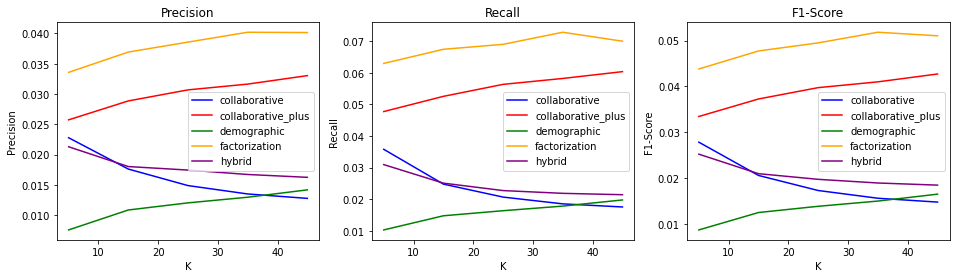

In [ ]:
import matplotlib.pyplot as plt

# Create three subplots for each evaluation metric
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Create a list of colors for the lines
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Loop through each evaluation metric and plot the lines for each model
for i, metric in enumerate(['Precision', 'Recall', 'F1-Score']):
    # Filter the data to only include the metric of interest
    metric_df = df[['K', 'Model', metric]]
    # Reshape the data so that each model has its own column
    metric_df = metric_df.pivot(index='K', columns='Model', values=metric)
    # Plot the lines for each model
    for j, model in enumerate(metric_df.columns):
        metric_df[model].plot(ax=axs[i], color=colors[j])
    # Set the title and labels for the subplot
    axs[i].set_title(metric)
    axs[i].set_xlabel('K')
    axs[i].set_ylabel(metric)
    axs[i].legend()

# Display the plots
plt.show()

In [ ]:
set(collaborative_res[1][1]).intersection(set(cols_to_zeros[1][1]))

In [ ]:
evaluation(collaborative_plus_res, cols_to_zeros)

In [ ]:
type(collaborative_plus_res[1][1])

numpy.ndarray

In [ ]:
type(cols_to_zeros[1][1])

list

### Schedl's Code & Implementing a Simple Recommendation System

In [ ]:
# Computes several statistics and provides some tools for the LFM-1b dataset of Last.fm listening histories.
# Author: Markus Schedl

import numpy as np
import h5py
from scipy import sparse

UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'                  # Matlab .mat file where the listening events are stored
STATISTICS_OUTPUT_FILE = 'LFM-1b_stats_users.txt'         # output file for statistics

# Read the user-artist-matrix and corresponding artist and user indices from Matlab file
def read_UAM(m_file):
    mf = h5py.File(m_file, 'r')
    user_ids = np.array(mf.get('idx_users')).astype(np.int64)
    artist_ids = np.array(mf.get('idx_artists')).astype(np.int64)
    # Load UAM
    UAM = sparse.csr_matrix((mf['/LEs/']["data"],
                             mf['/LEs/']["ir"],
                             mf['/LEs/']["jc"])).transpose()    #.tocoo().transpose()
    # user and artist indices to access UAM
    UAM_user_idx = UAM.indices #UAM.row -> for COO matrix
    UAM_artist_idx = UAM.indptr #UAM.col -> for COO matrix
    return UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids

# Read UAM
UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids = read_UAM(UAM_MATLAB_FILE)
print('Users: ', len(user_ids))
print('Artists: ', len(artist_ids))

# Compute some basic statistics
pc_sum = np.zeros((len(user_ids)), dtype=np.int32)              # to hold sum of playcounts, for all users
pc_uniq_artists = np.zeros((len(user_ids)), dtype=np.int32)     # to hold number of unique artists listened to, for all users
pc_mean = np.zeros((len(user_ids)), dtype=np.float32)            # to hold mean playcount per artist, for all users
pc_median = np.zeros((len(user_ids)), dtype=np.float32)          # to hold median of playcount per artist, for all users
pc_std = np.zeros((len(user_ids)), dtype=np.float32)             # to hold standard deviation of playcount per artist, for all users
#for i in range(0, len(user_ids)):
#    pc_i = UAM.getrow(i).toarray()                    # get playcount vector for user i
#    idx_nz = np.nonzero(pc_i)                         # indies of non-zero playcounts
#    pc_uniq_artists[i] = len(idx_nz[1])
#   pc_sum[i] = np.sum(pc_i[idx_nz])
#   pc_mean[i] = np.mean(pc_i[idx_nz])
#    pc_std[i] = np.std(pc_i[idx_nz])
#    pc_median[i] = np.median(pc_i[idx_nz])
    #print('User ' + str(i) +    "   Playcount: " + str(pc_sum[i]) + \
    #                            "   Unique artists: " + str(pc_uniq_artists[i]) + \
    #                            "   Mean PC/artist: " + str(pc_mean[i]) + \
    #                            "   Std. PC/artist: " + str(pc_std[i]) + \
    #                            "   Median PC/artist: " + str(pc_median[i]))

# Mean/std. of basic statistics
#print "Mean/std. of playcount: " + str(np.mean(pc_sum)) + " +- " + str(np.std(pc_sum))
#print "Mean/std. of unique artists: " + str(np.mean(pc_uniq_artists)) + " +- " + str(np.std(pc_uniq_artists))
#print "Mean/std. of mean PC/artist: " + str(np.mean(pc_mean)) + " +- " + str(np.std(pc_mean))
#print "Mean/std. of std. PC/artist: " + str(np.mean(pc_std)) + " +- " + str(np.std(pc_std))
#print "Mean/std. of median PC/artist: " + str(np.mean(pc_median)) + " +- " + str(np.std(pc_median))'''

Users:  120175
Artists:  585095


In [ ]:
# Implementation of a very simple and much to improve user-based collaborative filtering (CF) recommender.
# Author: Markus Schedl

# Load required modules
import csv
import numpy as np
import h5py
from scipy import sparse


UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'         # Matlab .mat file where the listening events are stored
ARTISTS_FILE = "LFM-1b_artists.txt"        # artist names for UAM
USERS_FILE = "LFM-1b_users.txt"            # user names for UAM
K = 3                                      # maximum number of seed's neighbors to select


# Read the user-artist-matrix and corresponding artist and user indices from Matlab file
def read_UAM(m_file):
    mf = h5py.File(m_file, 'r')
    user_ids = np.array(mf.get('idx_users')).astype(np.int64)
    artist_ids = np.array(mf.get('idx_artists')).astype(np.int64)
    # Load UAM
    UAM = sparse.csr_matrix((mf['/LEs/']["data"],
                             mf['/LEs/']["ir"],
                             mf['/LEs/']["jc"])).transpose()    #.tocoo().transpose()
    # user and artist indices to access UAM
    UAM_user_idx = UAM.indices #UAM.row -> for COO matrix
    UAM_artist_idx = UAM.indptr #UAM.col -> for COO matrix
    return UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids


# Function to read metadata (users or artists)
def read_from_file(filename, col):                  # col = column to read from file
    data = []
    with open(filename, 'r') as f:                  # open file for reading
        reader = csv.reader(f, delimiter='\t')      # create reader
        headers = next(reader)                     # skip header
        for row in reader:
            item = row[col]
            data.append(item)
    f.close()
    return data

In [ ]:
# Initialize variables
artists = []            # artists
users = []              # users

# Read UAM
UAM, UAM_user_idx, UAM_artist_idx, user_ids, artist_ids = read_UAM(UAM_MATLAB_FILE)
print('Users: ', len(user_ids))
print('Artists: ', len(artist_ids))

# Load metadata from provided files into lists
artists = read_from_file(ARTISTS_FILE, 1)
users = read_from_file(USERS_FILE, 0)

# For all users
#for u in range(0, UAM.shape[0]):
#  print("Seed user-id: " + str(users[u]))

#u =1000

# get (normalized) playcount vector for current user u
pc_vec = UAM.getrow(u)

# Compute similarities as dot product between playcount vector of user and all users via UAM (assuming that UAM is already normalized)
#        print uU_sim_users
uU_sim = pc_vec.dot(UAM.transpose()).tocoo()
uU_user_idx = uU_sim.col
uU_data = uU_sim.data

#
# Determine nearest neighbors to seed based on uUM
#

# Find the occurrence of the seed user in uU_data cols
# and set to 0 so that it is not selected as its own NN
occ_user_idx = (uU_user_idx == u)
uU_data[occ_user_idx] = 0

# Eliminate zeros
uU_sim.data = uU_data
uU_sim = uU_sim.tocsr()
uU_sim.eliminate_zeros()
uU_sim = uU_sim.tocoo()
uU_user_idx = uU_sim.col
uU_data = uU_sim.data

# Sort users according to the similarity (uU_data)
sort_index = np.argsort(uU_data)

# Select the K nearest neighbors among all users
# Note that uU_user_idx indeed provides the indices for users in UAM
recommended_user_idx = uU_user_idx[sort_index[-K:]]
# Get user_ids corresponding to nearest neighbors
recommended_user_ids = user_ids[recommended_user_idx]
# Get similarity score for nearest neighbors
recommended_user_scores = uU_data[sort_index[-K:]]

print("Nearest K=" + str(K) + " neighbors\' user-ids: ", recommended_user_ids.flatten())
# print('Scores/similarities:  ' + str(recommended_user_scores))
# print('Index in UAM for recommended user-ids: ' + str(recommended_user_idx))


# Determine set of recommended artists

recommended_artists_idx = []
for u_idx in recommended_user_idx:
    recommended_artists_idx.extend(list(UAM.getrow(u_idx).indices))

# Convert to set to remove duplicates and sort it
recommended_artists_idx = sorted(set(recommended_artists_idx))
# Remove artists already known to seed user
recommended_artists_idx = np.setdiff1d(recommended_artists_idx, pc_vec.indices)

print("Indices of " + str(len(recommended_artists_idx)) + " recommended artists: ", recommended_artists_idx)

Users:  120175
Artists:  585095


NameError: ignored